# **The Real Deal Behind the Artificial Appeal: Inferential Utility of Tabular Synthetic Data**

**(c) SYNDARA**

Results of the case study on the Adult Census Income dataset in "The Real Deal Behind the Artificial Appeal: Inferential Utility of Tabular Synthetic Data", presented during the 40th Conference on Uncertainty in Artificial Intelligence.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from adult_evaluate import adult_groundtruth
from utils.eval import missing_se, summary_table, coverage_run_plot
import scipy.stats as ss
import plotnine
from plotnine import *
from itertools import product

## Load meta data

In [3]:
case_dir = 'case_study1/'
meta_data = pd.read_csv(case_dir + 'meta_data.csv')

In [4]:
data_gt = adult_groundtruth(case_dir)

## Inspect meta data

In [5]:
meta_data.shape

(597, 17)

200 Monte Carlo runs, 1 original dataset, 2 generative models with 1 synthetic dataset per model, so 200x(1+2x1)=600 datasets. However, 'ctgan' (synthcity) could not be fitted for [run=146,155,174], so 600-3=597 datasets.

In [6]:
meta_data.head()

,Unnamed: 0,dataset_name,n,run,generator,age_mean,age_mean_se,income_>50K_age_logr,income_>50K_age_logr_se,sanity_common_rows_proportion,sanity_IKLD,age_mean_bias,age_mean_coverage,age_mean_coverage_corrected,income_>50K_age_logr_bias,income_>50K_age_logr_coverage,income_>50K_age_logr_coverage_corrected
0,0,synthpop_0,5000,run_0,synthpop,38.513446,0.184216,0.043131,0.002583,0.0,0.959997,-0.016709,True,True,0.001879,True,True
1,1,ctgan_0,5000,run_0,ctgan,36.401000,0.163183,0.045655,0.002994,0.0,0.922302,-2.129155,False,False,0.004403,True,True
2,2,original_data,5000,run_0,original,38.254000,0.188166,0.043709,0.002564,1.0,1.000000,-0.276155,True,True,0.002456,True,True
3,3,synthpop_0,5000,run_1,synthpop,38.239658,0.181952,0.043912,0.002577,0.0,0.958695,-0.290497,True,True,0.002660,True,True
4,4,ctgan_0,5000,run_1,ctgan,31.884400,0.159579,0.041885,0.003002,0.0,0.929030,-6.645755,False,False,0.000632,True,True


## Missing estimates

In [7]:
data_missing = missing_se(meta_data)

In [8]:
print('TOTAL: ' + str(sum(data_missing['estimator'].value_counts())))

TOTAL: 0


## Average IKLD

**Table (appendix)**

In [9]:
meta_data.groupby(['n', 'generator'])['sanity_IKLD'].mean().reset_index().melt(
    id_vars=['n', 'generator'],
    var_name='estimator',
    value_name='IKLD').drop(columns=['n', 'estimator'])

,generator,IKLD
0,ctgan,0.923359
1,original,1.000000
2,synthpop,0.955407


## Relative errors

**Table (main text)**

In [10]:
# Presets
order_generators = ['original', 'synthpop', 'ctgan']
select_metrics = ['relative_bias', 'SE_underestimation']

# Display summary table
summary_data = summary_table(meta_data, ground_truth=data_gt) 
summary_data = summary_data.drop('n', axis=1).pivot(index='estimator', columns='generator')
summary_data = summary_data.swaplevel(0, 1, axis=1).sort_index(axis=1).reindex(columns=list(product(order_generators, select_metrics)))
(summary_data*100).style.format(precision=2) # in percentage

# Coverage

**Table (main text)**

In [11]:
# Presets
select_estimators = [column for column in meta_data.columns if '_coverage' in column]
order_generators = ['original', 'synthpop', 'ctgan']
order_corrected = ['no', 'yes']

# Display table
coverage_data = meta_data.groupby('generator')[select_estimators].mean().reset_index().melt(
    id_vars='generator',
    value_vars=select_estimators,
    var_name='estimator',
    value_name='coverage')
coverage_data['corrected'] = list(map(lambda x: 'yes' if 'corrected' in x else 'no', coverage_data['estimator']))
coverage_data['estimator'] = list(map(lambda x: 'age_mean' if 'age_mean' in x else 'income_>50K_age_logr', coverage_data['estimator']))
coverage_data = coverage_data.pivot(index='estimator', columns=['generator', 'corrected'])[list(product(['coverage'], order_generators, order_corrected))]
(coverage_data*100).style.format(precision=2) # in percentage

**Plot (main text)**

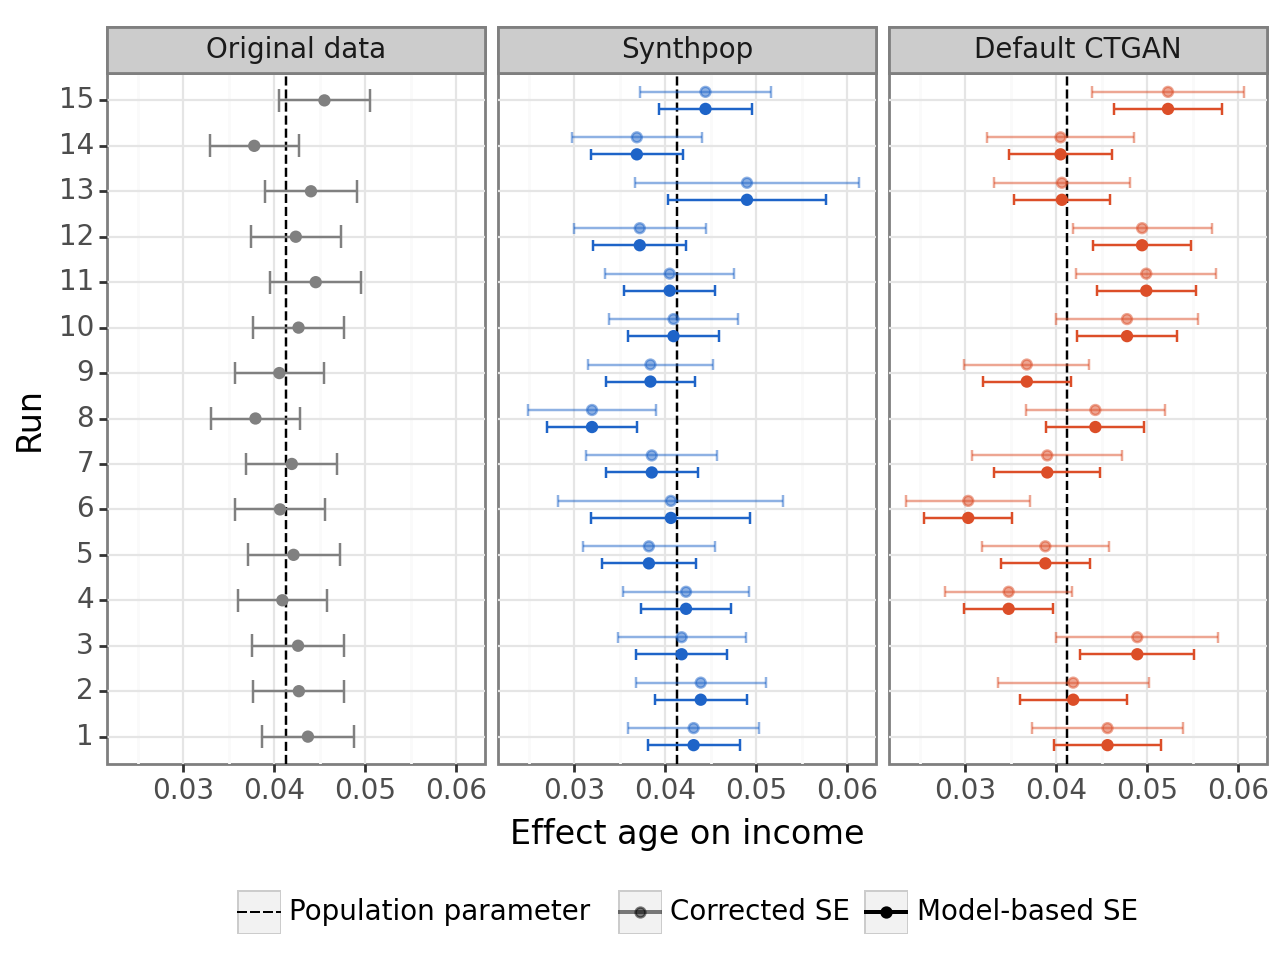

<Figure Size: (640 x 480)>

In [14]:
# Relabel
relabel_generators = {'original': 'Original data', 
                      'ctgan': 'Default CTGAN',
                      'synthpop': 'Synthpop'}

# Plot
coverage_run_plot(meta_data, 
                  select_estimator='income_>50K_age_logr', 
                  order_generators=['original', 'synthpop', 'ctgan'],
                  ground_truth=data_gt,
                  quantile=0.975,
                  n_runs=15,
                  figure_size=(6.4,4.8)) +\
    facet_wrap('generator', labeller=labeller(cols=lambda x: relabel_generators[x])) +\
    labs(y='Effect age on income')

**Plot (appendix)**

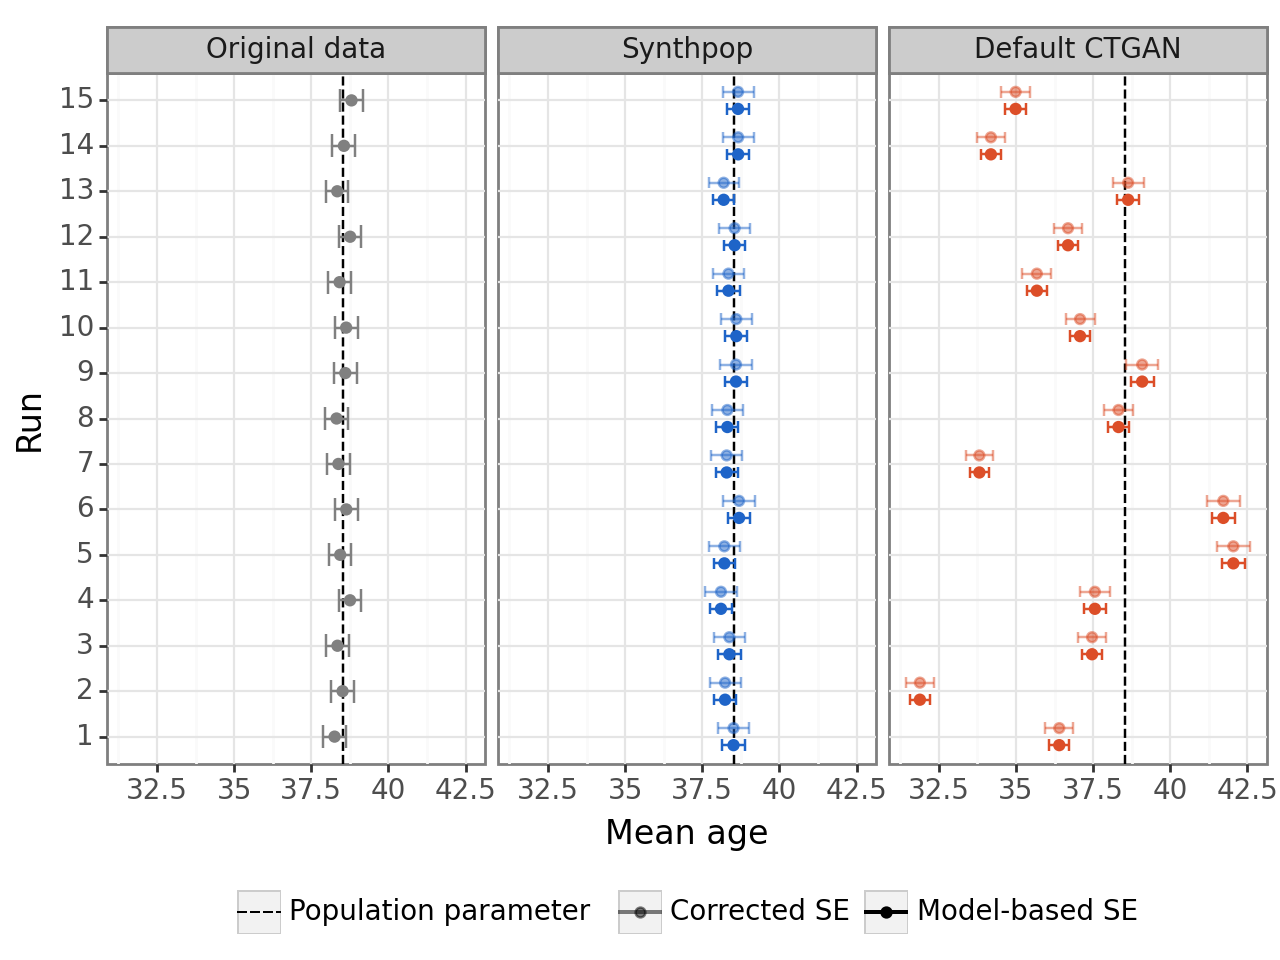

<Figure Size: (640 x 480)>

In [15]:
# Relabel
relabel_generators = {'original': 'Original data', 
                      'ctgan': 'Default CTGAN',
                      'synthpop': 'Synthpop'}

# Plot
coverage_run_plot(meta_data, 
                  select_estimator='age_mean', 
                  order_generators=['original', 'synthpop', 'ctgan'],
                  ground_truth=data_gt,
                  quantile=0.975,
                  n_runs=15,
                  figure_size=(6.4,4.8)) +\
    facet_wrap('generator', labeller=labeller(cols=lambda x: relabel_generators[x])) +\
    labs(y='Mean age')

# Sanity check: common rows

**Table (appendix)**

In [16]:
meta_data.query('sanity_common_rows_proportion != 0 & generator != \'original\'')[['dataset_name', 'n', 'run', 'generator', 'sanity_common_rows_proportion']].sort_values(by=['generator', 'n'])

,dataset_name,n,run,generator,sanity_common_rows_proportion
12,synthpop_0,5000,run_4,synthpop,0.0002
481,synthpop_0,5000,run_161,synthpop,0.0002
585,synthpop_0,5000,run_196,synthpop,0.0002
